## Setup

### Imports

In [12]:
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils
from stocksense.api import data as api_data

In [13]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [14]:
TRAIN = True

### Data

In [15]:
stock_list = ['MSFT', 'AAPL', 'AXP', 'AMGN', 'CSCO', 'HON', 'IBM', 'KO']

dfs_train = [await api_data.get_kline_df('yfinance', i, datetime(2000, 1, 1), datetime(2022, 12, 31), '1d') for i in stock_list]
assert all([i.shape == dfs_train[0].shape for i in dfs_train])

############# dataset for validation
size = len(dfs_train[0])
dfs_validation = list(map(lambda x: x.iloc[int(size*0.8):, :], dfs_train))
dfs_train = list(map(lambda x: x.iloc[0:int(size*0.8), :], dfs_train))
#############

# dfs_validation = dfs_train

dfs_test = [await api_data.get_kline_df('yfinance', i, datetime(2023, 1, 1), datetime(2024, 12, 1), '1d') for i in stock_list]
assert all([i.shape == dfs_test[0].shape for i in dfs_test])

df_dji = await api_data.get_kline_df('yfinance', '^DJI', datetime(2023, 1, 1), datetime(2024, 12, 1), '1d')

print(dfs_train[0].shape)
print(dfs_validation[0].shape)
print(dfs_test[0].shape)
print(df_dji.shape)

(4629, 6)
(1158, 6)
(481, 6)
(481, 6)


### Environment

In [16]:
env_kwargs = {
    'trading_fees': 0.01/100,
    'windows': 5
}
env = scenv.MultiStockTradingEnv(name= "MY_ENV", dfs=dfs_train, **env_kwargs)
env_for_buy_and_hold = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_BUY_AND_HOLD", dfs=dfs_test, strategy='buy_and_hold', **env_kwargs)
env_for_dji = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_DJI", dfs=[df_dji], strategy='buy_and_hold', **env_kwargs)
env_test = scenv.MultiStockTradingEnv(name= "MY_ENV_TEST", dfs=dfs_test, **env_kwargs)
eval_env = scenv.MultiStockTradingEnv(name= "MY_ENV_VALIDATION", dfs=dfs_validation, **env_kwargs)

### Validation Callback Function

In [17]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecEnv
from typing import Union
import numpy as np
import gymnasium as gym

class CustomEvalCallback(BaseCallback):
    """
    :param eval_env: The environment for validation
    :param eval_freq: Evaluate the agent every 'eval_freq' call of the callback
    :param n_eval_episodes: The number of episodes to test the agent
    :param log_path: Path to a folder where the evaluations ('evaluations.npz') will be saved. It will be updated at each evaluation
    """
    def __init__(
        self, 
        eval_env: Union[gym.Env, VecEnv], 
        eval_freq: int = 1000, 
        n_eval_episodes: int = 5, 
        log_path: str = "./logs",
        verbose: int = 1
    ):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.log_path = log_path

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        # Use to cut the sections
        print("Training --- ")

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        :return: If the callback returns False, training is aborted early.
        """
        if self.num_timesteps % self.eval_freq == 0:
            return_values = [] # stores the returned Portfolios for calculating average
            mean_reward = self.evaluate_model(return_values)
            self.custom_log(return_values)
        return True

    def evaluate_model(self, return_values: list):
        """
        Evaluate the model performance in validation env
        """
        print("Validation --- ")
        for episode in range(self.n_eval_episodes):
            episode_reward = []
            done, truncated = False, False
            obs, info = self.eval_env.reset()
            while not done and not truncated:
                action, _states = self.model.predict(obs)
                obs, rewards, done, truncated, info = self.eval_env.step(action)
            history_dqn = self.eval_env.get_history()
            episode_reward.append(rewards)
            return_values.append(100*(history_dqn[-1] / history_dqn[0] -1))
        
        mean_reward = np.mean(episode_reward)
        return mean_reward

    def custom_log(self, return_values: list):
        """
        Output imformation
        """
        print(f"At Step {self.num_timesteps}, Average Protfolio return over {self.n_eval_episodes} episodes: {np.mean(return_values):5.2f}%")
        print("Training --- ")


## Baseline: Random Agent

In [18]:
done, truncated = False, False
observation, info = env_test.reset()
while not done and not truncated:
    action = env_test.action_space.sample()
    observation, reward, done, truncated, info = env_test.step(action)
history_random = env_test.get_history()

Portfolio Return : 64.32%


## Baseline: Buy and Hold

In [19]:
done, truncated = False, False
observation, info = env_for_buy_and_hold.reset()
while not done and not truncated:
    action = [1/len(stock_list)] * (len(stock_list)) + [0]
    observation, reward, done, truncated, info = env_for_buy_and_hold.step(action)
history_buy_and_hold = env_for_buy_and_hold.get_history()
print(history_buy_and_hold[0], history_buy_and_hold[-1])

Portfolio Return : 32.12%
1000.0 1321.1602535287127


## Baseline: DJI

In [20]:
done, truncated = False, False
observation, info = env_for_dji.reset()
while not done and not truncated:
    action = [1, 0]
    observation, reward, done, truncated, info = env_for_dji.step(action)
history_dji = env_for_dji.get_history()

Portfolio Return : 29.87%


## Agent: DQN

In [21]:
policy_kwargs = {
    'net_arch': [128, 128]
}
hparas = {
    'batch_size': 128,
    'gamma': 0.99,
    'exploration_initial_eps': 0.9,
    'exploration_final_eps': 0.05,
    'exploration_fraction': 0.001,
    'target_update_interval': 10000,
    'learning_rate': 1e-4,
    'buffer_size': 10000,
    'policy_kwargs': policy_kwargs,
    # 'tensorboard_log': 'dqn_tensorboard'
}

In [22]:
from stable_baselines3 import DQN

eval_callback = CustomEvalCallback(eval_env=eval_env, eval_freq=10000, n_eval_episodes=1)

if (TRAIN):
    model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 15, callback=eval_callback)
    model.save("dqn")

model = DQN.load("dqn")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
history_dqn = env_test.get_history()

Training --- 
Portfolio Return : 196.42%
Portfolio Return : 3279.62%
Validation --- 
Portfolio Return : 78.49%
At Step 10000, Average Protfolio return over 1 episodes: 78.49%
Training --- 
Portfolio Return : 20986.45%
Portfolio Return : 32373.43%
Validation --- 
Portfolio Return : 73.86%
At Step 20000, Average Protfolio return over 1 episodes: 73.86%
Training --- 
Portfolio Return : 42103.83%
Portfolio Return : 17713.87%
Validation --- 
Portfolio Return : 77.25%
At Step 30000, Average Protfolio return over 1 episodes: 77.25%
Training --- 
Portfolio Return : 196688.68%
Portfolio Return : 912653.68%
Validation --- 
Portfolio Return : 208.05%
At Step 40000, Average Protfolio return over 1 episodes: 208.05%
Training --- 
Portfolio Return : 705796.52%
Portfolio Return : 826804.90%
Portfolio Return : 8727650.96%
Validation --- 
Portfolio Return : 185.08%
At Step 50000, Average Protfolio return over 1 episodes: 185.08%
Training --- 
Portfolio Return : 8294319.16%
Portfolio Return : 12237205.3

## Agent: DQN-overfitting

In [ ]:
if (TRAIN):
    model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 60)
    model.save("dqn-overfitting")

model = DQN.load("dqn-overfitting")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
history_dqn_overfitting = env_test.get_history()

Portfolio Return : 241.55%
Portfolio Return : 1151.87%
Portfolio Return : 940.54%
Portfolio Return : 9483.44%
Portfolio Return : 20402.76%
Portfolio Return : 18805.76%
Portfolio Return : 13077.14%
Portfolio Return : 218548.12%
Portfolio Return : 116813.00%
Portfolio Return : 822854.95%
Portfolio Return : 1293472.98%
Portfolio Return : 6470941.98%
Portfolio Return : 8310188.13%
Portfolio Return : 5636481.24%
Portfolio Return : 42387078.18%
Portfolio Return : 22878928.92%
Portfolio Return : 86956298.75%
Portfolio Return : 192276715.09%
Portfolio Return : 98635389.89%
Portfolio Return : 143511020.66%
Portfolio Return : 619429972.65%
Portfolio Return : 11009133001.73%
Portfolio Return : 4362309135.11%
Portfolio Return : 1155187321.98%
Portfolio Return : 9171145572.16%
Portfolio Return : 8305275765.88%
Portfolio Return : 43082716607.37%
Portfolio Return : 29107633022.29%
Portfolio Return : 40983802525.41%
Portfolio Return : 12824505680.98%
Portfolio Return : 48100616740.22%
Portfolio Return

## Agent: A2C

In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

if (TRAIN):
    model = A2C('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 15)
    model.save("a2c")

model = A2C.load("a2c", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
history_a2c = env_test.get_history()

Portfolio Return : 58.60%
Portfolio Return : 417.45%
Portfolio Return : 11143.99%
Portfolio Return : 9334.63%
Portfolio Return : 12336.36%
Portfolio Return : 12528.40%
Portfolio Return : 12070.20%
Portfolio Return : 12349.80%
Portfolio Return : 12416.43%
Portfolio Return : 12354.72%
Portfolio Return : 12472.22%
Portfolio Return : 12349.80%
Portfolio Return : 12349.80%
Portfolio Return : 12349.80%
Portfolio Return : 12349.80%
predicting...
Portfolio Return : 33.18%


## Agent: PPO

In [ ]:
from stable_baselines3 import PPO

if (TRAIN):
    model = PPO('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 15)
    model.save("ppo")

model = PPO.load("ppo", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env_test.step(action)
history_ppo = env_test.get_history()

Portfolio Return : 90.91%
Portfolio Return : 141.04%
Portfolio Return : 27.78%
Portfolio Return : 192.67%
Portfolio Return : 376.04%
Portfolio Return : -71.13%
Portfolio Return : 93.63%
Portfolio Return : 421.95%
Portfolio Return : 304.18%
Portfolio Return : 175.01%
Portfolio Return : -23.10%
Portfolio Return :  9.78%
Portfolio Return : 1265.89%
Portfolio Return : -0.49%
Portfolio Return : 183.57%
predicting...
Portfolio Return : 35.45%


### Visualization

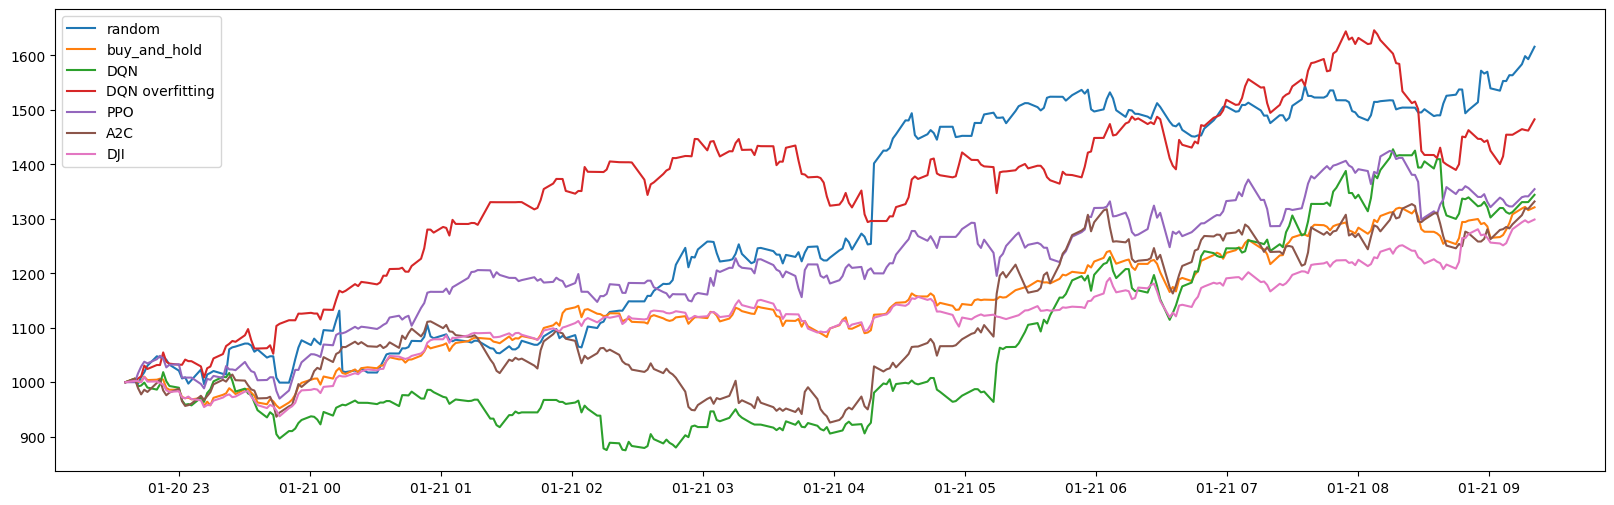

In [ ]:
y_axis = [datetime.fromtimestamp(i//1000) for i in env_test.get_date()[4:]]
plt.figure(figsize=(20, 6))
plt.plot(y_axis, history_random, label="random")
plt.plot(y_axis, history_buy_and_hold, label="buy_and_hold")
plt.plot(y_axis, history_dqn, label="DQN")
plt.plot(y_axis, history_dqn_overfitting, label="DQN overfitting")
plt.plot(y_axis, history_ppo, label="PPO")
plt.plot(y_axis, history_a2c, label="A2C")
plt.plot(y_axis, history_dji, label="DJI")
plt.legend()
plt.show()

In [ ]:
df_solution = pd.DataFrame()
df_solution['unix'] = env_test.get_date()[4:]
df_solution['account_value_dqn'] = history_dqn
df_solution['daily_return_dqn'] = df_solution['account_value_dqn'].pct_change(1)
df_solution['account_value_dqn_overfitting'] = history_dqn_overfitting
df_solution['daily_return_dqn_overfitting'] = df_solution['account_value_dqn_overfitting'].pct_change(1)
df_solution['account_value_a2c'] = history_a2c
df_solution['daily_return_a2c'] = df_solution['account_value_a2c'].pct_change(1)
df_solution['account_value_ppo'] = history_ppo
df_solution['daily_return_ppo'] = df_solution['account_value_ppo'].pct_change(1)
print(df_solution.head(5))
# store the solution
df_solution.to_csv('solution.csv', index=False)

                                 unix  account_value_dqn  daily_return_dqn  \
date                                                                         
2023-09-08 00:00:00+00:00  1694131200        1000.000000               NaN   
2023-09-11 00:00:00+00:00  1694390400        1006.521899          0.006522   
2023-09-12 00:00:00+00:00  1694476800         992.212508         -0.014217   
2023-09-13 00:00:00+00:00  1694563200         993.908190          0.001709   
2023-09-14 00:00:00+00:00  1694649600         999.334393          0.005459   

                           account_value_dqn_overfitting  \
date                                                       
2023-09-08 00:00:00+00:00                    1000.000000   
2023-09-11 00:00:00+00:00                    1002.440616   
2023-09-12 00:00:00+00:00                    1006.696039   
2023-09-13 00:00:00+00:00                    1010.760927   
2023-09-14 00:00:00+00:00                    1030.478776   

                           daily